# ePSproc function defn tests
13/08/19

## Wigner D

Compare existing ePSproc_wignerD.m (Matlab, matches Zare defn.) to Moble's quaternion-based version (matches Wikipedia defn.).

Defns....

See:

- [Wikipedia defn.](https://en.wikipedia.org/wiki/Wigner_D-matrix#Definition_of_the_Wigner_D-matrix)
- Moble's notes:
    - [WignerD defn.](https://moble.github.io/spherical_functions/WignerDMatrices.html)
    - [Note on Euler angles](https://moble.github.io/spherical_functions/#euler-angles)
    - [Comparison with Mathematica and Sympy definitions](https://github.com/moble/spherical_functions/blob/master/Notes/conventions.ipynb)
        
    
Summary:
- Moble's WignerD defn. matches wikipedia.
- Euler angle defns. also consistent, $(\alpha, \beta, \gamma) \equiv (\phi, \theta, \chi)$.
- Zare defns, eqns. 3.54-3.55, as used in ePSproc, is *conjugate* form (as compared to wiki defn.).
- Python calcs should match Matlab conj(ePSproc_wignerD.m), either defined numreically or via algebraic defn.
- Python calcs ~2 orders of magnitude faster than (admittedly unoptimized) Matlab ePSproc codes.^

^ Benchmarks run on a [Threadripper 1950X](https://www.amd.com/en/products/cpu/amd-ryzen-threadripper-1950x) machine. The python calcs. barely troubled one core; the Matlab calcs were highly inefficient (lots of loops) and used ~30 - 50% of a single core... for much longer. On an [Atom-based cheap laptop](https://www.asus.com/us/2-in-1-PCs/ASUS-Transformer-Mini-T102HA/specifications/) the python numbers were still ~1 order of magnitude faster.  See below for details.


### Basic test

In [1]:
# Imports
import numpy as np
import spherical_functions as sf
import quaternion
import matplotlib.pyplot as plt

In [2]:
#%% Basic test with Euler angles

alpha, beta, gamma = 0.1, 0.2, 0.3
ell,mp,m = 3,2,1
wD_euler = sf.Wigner_D_element(alpha, beta, gamma, ell, mp, m)
print(wD_euler)

(-0.2647616388657892-0.14463994252750317j)


In [3]:
#%% With quaternion
R = np.quaternion(1,2,3,4).normalized()
wD_quat = sf.Wigner_D_element(R, ell, mp, m)
print(wD_quat)

(-0.25825267558041726-0.0653537383101466j)


In [4]:
#%% With quaternion defined by Euler angles
R_euler = quaternion.from_euler_angles(alpha, beta, gamma)
wD_eQuat = sf.Wigner_D_element(R_euler, ell, mp, m)
print(wD_eQuat)

# Check
print(wD_eQuat - wD_euler)

(-0.2647616388657892-0.14463994252750317j)
0j


### Benchmark vs ePSproc_wignerD.m (Matlab)

In [5]:
#%% WignerD bench
#   Adapted directly from Matlab code

# Set QNs for calculation, (l,m,mp)
Lmax = 6
QNs = []

for l in np.arange(0, Lmax+1):
    for m in np.arange(-l, l+1):
        for mp in np.arange(-l, l+1):
            QNs.append([l, m, mp])
            
QNs = np.array(QNs)
            
# Set a range of Eugler angles for testing
Nangs = 1000
pRot = np.linspace(0,180,Nangs)
tRot = np.linspace(0,90,Nangs)
cRot = np.linspace(0,180,Nangs)
eAngs = np.array([pRot, tRot, cRot,])*np.pi/180

# Convert to quaternions 
R =  quaternion.from_euler_angles(pRot*np.pi/180, tRot*np.pi/180, cRot*np.pi/180)

#****** wignerD vectorised for QN OR angles
wD_QNs = []
for n in np.arange(0, QNs.shape[0]): 
    wD_QNs.append([QNs[n,:], R, sf.Wigner_D_element(R, QNs[n,0], QNs[n,1], QNs[n,2])])


In [6]:
#%% Compare with Matlab results
from scipy.io import loadmat
x = loadmat(r'wignerD_bench_090819.mat')
wD_QNsMatlab = x['wD_QNs']

def wD_sortf(wD_QNs, conjPy = True):
    # Sort to array for comparison
    wD_sort=[]
    if conjPy:
        # With conjugate on Python results
        [wD_sort.extend(np.c_[np.tile(wD[0],(wD[2].shape[0],1)), wD[2].conj()]) for wD in wD_QNs]

    else:
        # For QN looped case
        [wD_sort.extend(np.c_[np.tile(wD[0],(wD[2].shape[0],1)), wD[2]]) for wD in wD_QNs]

        # For angle looped case
        # [wD_sort.extend(np.c_[wD[0], wD[2]]) for wD in wD_QNs]  

    return np.asarray(wD_sort)


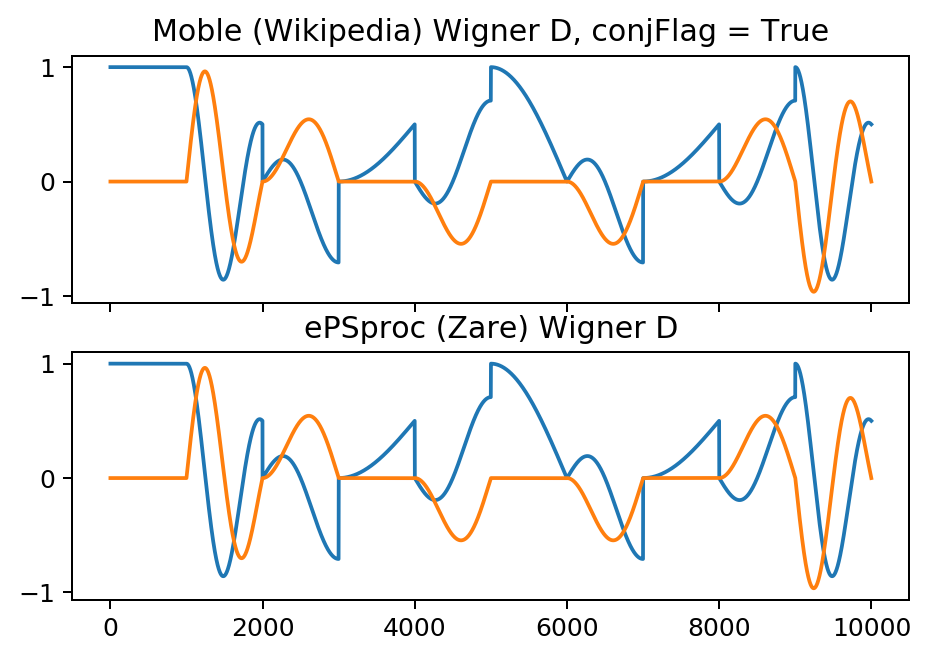

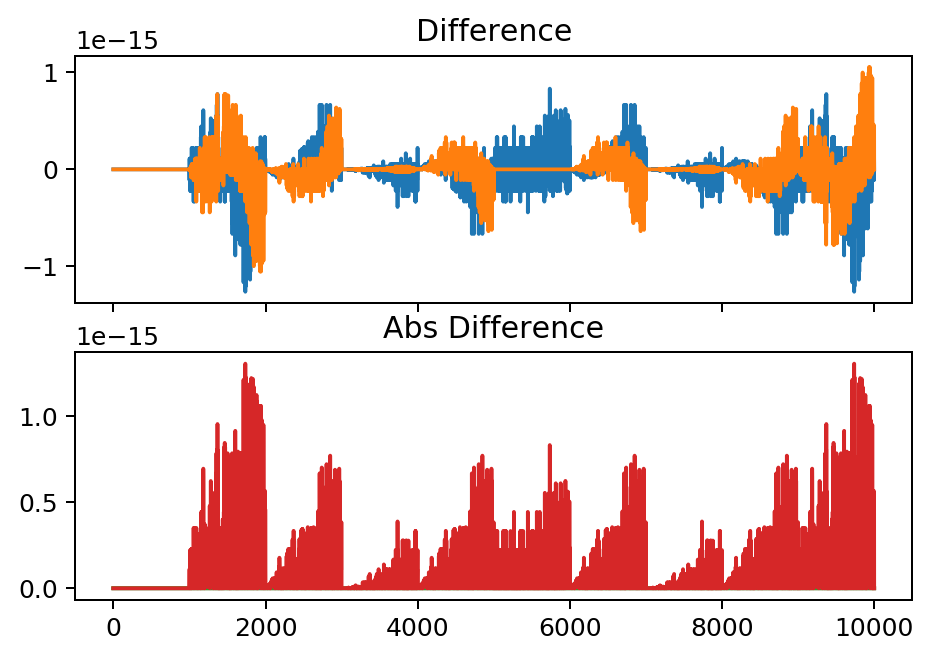

(4.773959005888173e-15+8.326672684688674e-16j)

In [7]:
conjFlag = True
wD_sort = wD_sortf(wD_QNs, conjPy = conjFlag)

# Subtract and plot
wD_test = wD_sort - wD_QNsMatlab[:,0:4]

# Set plot params
pRange = np.arange(1,10000)
sPlots = 4
colPlot = 3  # Set as index into python results

fig, ax = plt.subplots(2, 1, sharex='col', dpi=180)
ax[0].plot(np.c_[np.real(wD_sort[pRange,colPlot]), np.imag(wD_sort[pRange,colPlot])])
ax[0].set_title('Moble (Wikipedia) Wigner D, conjFlag = ' + str(conjFlag))

ax[1].plot(np.c_[np.real(wD_QNsMatlab[pRange,colPlot]), np.imag(wD_QNsMatlab[pRange,colPlot])])
ax[1].set_title('ePSproc (Zare) Wigner D')

fig, ax = plt.subplots(2, 1, sharex='col', dpi=180)
ax[0].plot(np.c_[np.real(wD_test[pRange,colPlot]), np.imag(wD_test[pRange,colPlot])])
ax[0].set_title('Difference')

#plt.subplot(sPlots,1,4)
ax[1].plot(np.abs(wD_test[pRange,:]))
ax[1].set_title('Abs Difference')
plt.show()

# Check values
wD_test.max()


**> For conjugate version, differences on order of 1e-15. OK.**

### Timings

Timings pretty consistent for list comp vs. loop.

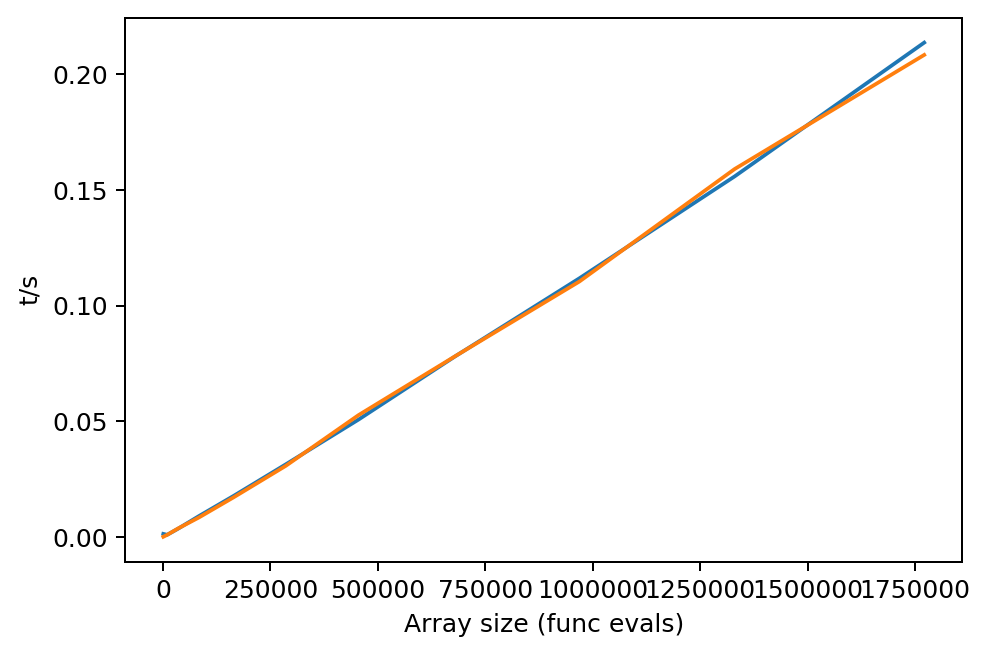

In [8]:
# Try timing as wall clock for more flexibility...
# https://www.techbeamers.com/python-time-functions-usage-examples/
# Get similar results for time.time(), time.clock() and time.perf_counter()
import time

tS = time.perf_counter()
tBench = []
fEvals = []

# Set QNs for calculation, (l,m,mp)
for Lmax in np.arange(0,11):
    QNs = []

    for l in np.arange(0, Lmax+1):
        for m in np.arange(-l, l+1):
            for mp in np.arange(-l, l+1):
                QNs.append([l, m, mp])

    QNs = np.array(QNs)
    
    tQN = time.perf_counter()
    
    #****** wignerD vectorised for QN OR angles
    wD_QNs = []
    for n in np.arange(0, QNs.shape[0]): 
        wD_QNs.append([QNs[n,:], R, sf.Wigner_D_element(R, QNs[n,0], QNs[n,1], QNs[n,2])])
    
    tLoop = time.perf_counter()
    
    wD_QNs = []
    [wD_QNs.append([QN, R, sf.Wigner_D_element(R, QN[0], QN[1], QN[2])]) for QN in QNs]
    
    tBench.append([tQN, tLoop, time.perf_counter()])
    fEvals.append([Lmax, len(wD_QNs)*len(R)])
    
tBench = np.asarray(tBench)
tDeltas = np.c_[tBench[:,1]-tBench[:,0], tBench[:,2]-tBench[:,1]]
# print(tDeltas)

# Plot
fEvals = np.asarray(fEvals)
plt.figure(dpi = 180)
plt.plot(fEvals[:,1], tDeltas)
plt.xlabel('Array size (func evals)')
plt.ylabel('t/s')
plt.show()

**> Compare with Matlab code - massively faster...**

(Benchmarks on a [Threadripper 1950X](https://www.amd.com/en/products/cpu/amd-ryzen-threadripper-1950x) machine.  On an [Atom-based cheap laptop](https://www.asus.com/us/2-in-1-PCs/ASUS-Transformer-Mini-T102HA/specifications/) the python numbers here topped out at 1.4s, so were still massively faster (Matlab benchmarks were not tested on that machine).)

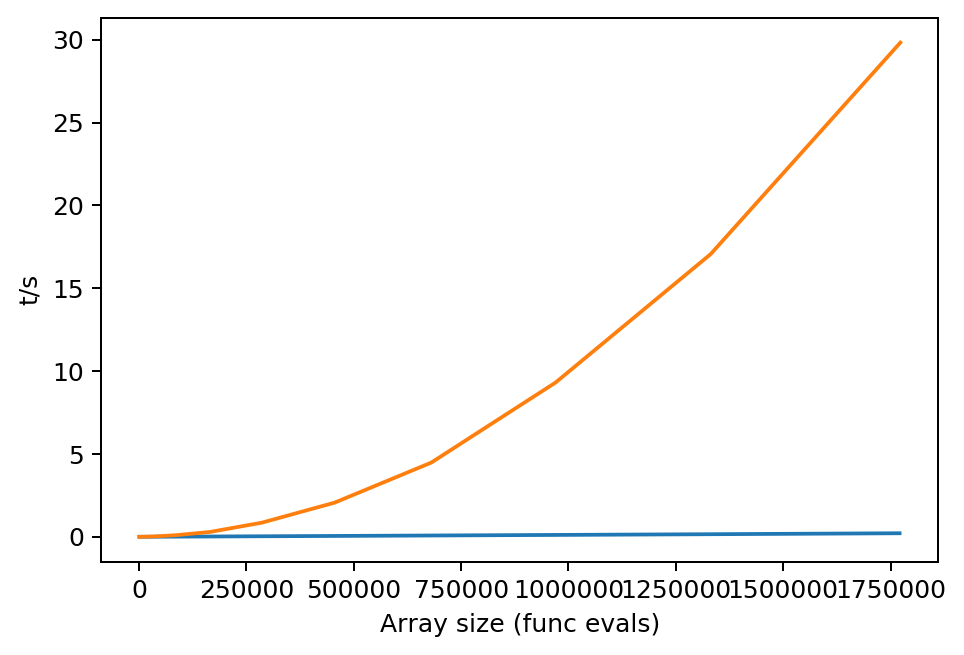

Check fEvals for consistency:
[   0.    9.   34.   83.  164.  285.  454.  679.  968. 1329. 1770.]


In [9]:
# Compare with Matlab benchmarks (not even funny...!)
x = loadmat(r'wignerD_bench_t_090819.mat') 
wDBenchMatlab = x['wDbench']

plt.figure(dpi = 180)
# plt.plot(fEvals[:,1],np.c_[tDeltas[:,0], wDBenchMatlab[1:,3]])
plt.plot(fEvals[:,1], tDeltas[:,0])
plt.plot(wDBenchMatlab[1:,2], wDBenchMatlab[1:,3])
plt.xlabel('Array size (func evals)')
plt.ylabel('t/s')
plt.show()

print('Check fEvals for consistency:')
print(wDBenchMatlab[1:,2] - fEvals[:,1])

Note slight difference in overall fn. evals (probably an extraneous extra loop in Matlab code), but won't make a significant difference here.

## Wigner 3j

Should be consistent...
- [Moble's functions](https://github.com/moble/spherical_functions/blob/master/Wigner3j.py) based on Sympy.
- Sympy matches Zare defn.
- ePSproc matches Zare defn.

## Basic test

In [10]:
#%% Basic tests
#       See https://github.com/moble/spherical_functions/blob/master/Wigner3j.py
#       Syntax Wigner3j(j_1, j_2, j_3, m_1, m_2, m_3)
#       Integer values only, and single values only?

print(sf.Wigner3j(2, 6, 4, 0, 0, 0))

print(sf.Wigner3j(2, 6, 4, 0, 0, 1))

0.18698939800169143
0.0


### Benchmark vs. ePSproc_3j.m (Matlab, Zare defns.)

In [11]:
#%% Test set of values

Lmax = 6
QNs = []

for l in np.arange(0, Lmax+1):
    for lp in np.arange(0, Lmax+1):
        for m in np.arange(-l, l+1):
            for mp in np.arange(-lp, lp+1):
                for L in np.arange(0, l+lp+1):
                    M = -(m+mp)
                    QNs.append([l, lp, L, m, mp, M])
                    
QNs = np.array(QNs)

# Test vector compatibility - NOPE... but pretty fast anyway
# test = sf.Wigner3j(QNs[:,0], QNs[:,1], QNs[:,2], QNs[:,3], QNs[:,4], QNs[:,5])

# LOOP OVER QNs and calculate
w3j_QNs = []
for n in np.arange(0, QNs.shape[0]): 
    w3j_QNs.append([QNs[n,:], sf.Wigner3j(QNs[n,0], QNs[n,1], QNs[n,2], QNs[n,3], QNs[n,4], QNs[n,5])])
    

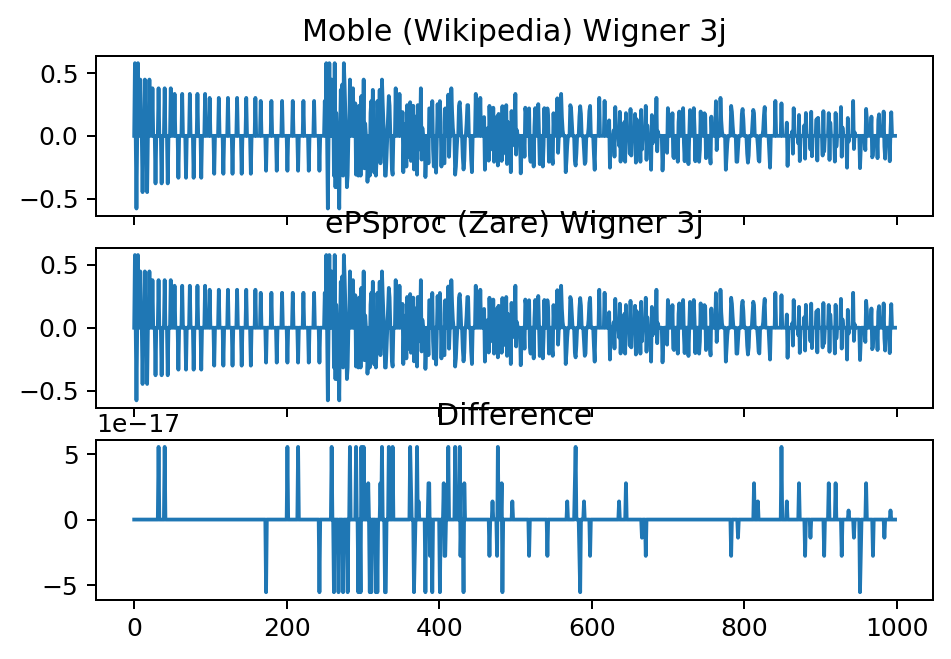

(4.773959005888173e-15+8.326672684688674e-16j)

In [12]:
#%% Test vs. Matlab reference
from scipy.io import loadmat
x = loadmat(r'wigner3j_bench_L6_130819.mat') 
w3j_QNsMatlab = x['QNs_3j']

# Sort to array for comparison - WORKS, but UGLY.  Should be a better way?
w3j_sort=[]
[w3j_sort.append(np.r_[wD[0], wD[1]]) for wD in w3j_QNs]
w3j_sort = np.array(w3j_sort)

# Subtract and plot
w3j_test = w3j_sort - w3j_QNsMatlab[:,0:7]

# Set plot params
pRange = np.arange(1,1000)
sPlots = 3
colPlot = 6  # Set as index into python results


fig, ax = plt.subplots(sPlots, 1, sharex='col', dpi=180)
ax[0].plot(w3j_sort[pRange,colPlot])
ax[0].set_title('Moble (Wikipedia) Wigner 3j')

ax[1].plot(w3j_QNsMatlab[pRange,colPlot])
ax[1].set_title('ePSproc (Zare) Wigner 3j')

ax[2].plot(w3j_test[pRange,colPlot])
ax[2].set_title('Difference')

# plt.subplot(sPlots,1,4)
# plt.plot(np.abs(w3j_test))
# plt.title('Abs Difference')
plt.show()


# Check values
wD_test.max()

**> Differences on order 1e-16. OK.**

## Timings

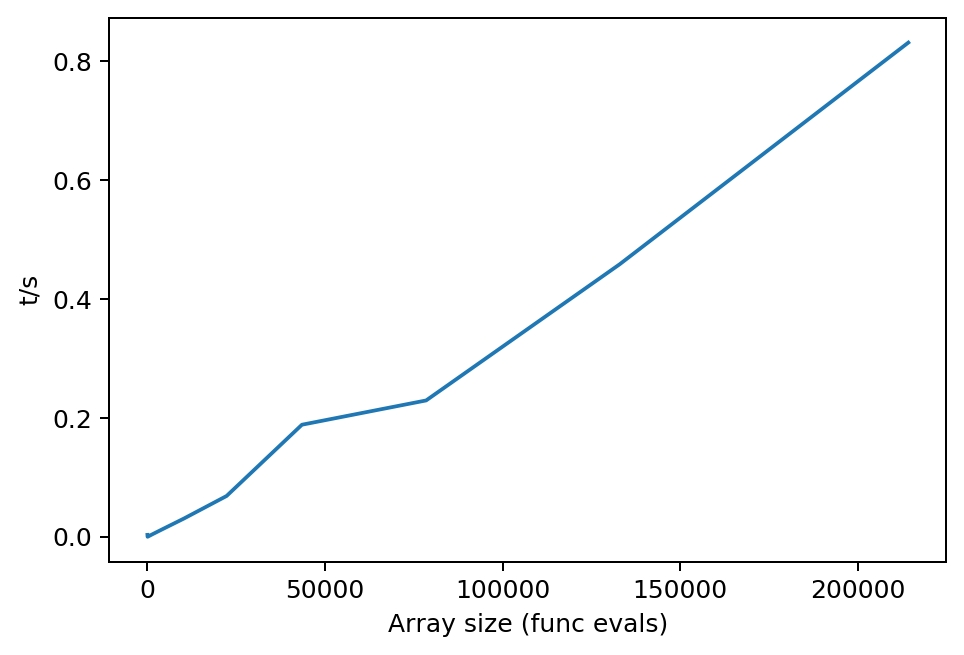

In [13]:
# Try timing as wall clock for more flexibility...
# https://www.techbeamers.com/python-time-functions-usage-examples/
# Get similar results for time.time(), time.clock() and time.perf_counter()
import time

tS = time.perf_counter()
tBench = []
fEvals = []

# Set QNs for calculation, (l,m,mp)
for Lmax in np.arange(0,11):
    QNs = []

    for l in np.arange(0, Lmax+1):
        for lp in np.arange(0, Lmax+1):
            for m in np.arange(-l, l+1):
                for mp in np.arange(-lp, lp+1):
                    for L in np.arange(0, l+lp+1):
                        M = -(m+mp)
                        QNs.append([l, lp, L, m, mp, M])

    QNs = np.array(QNs)
    
    tQN = time.perf_counter()
    
    #****** LOOP OVER QNs and calculate
    w3j_QNs = []
    for n in np.arange(0, QNs.shape[0]): 
        w3j_QNs.append([QNs[n,:], sf.Wigner3j(QNs[n,0], QNs[n,1], QNs[n,2], QNs[n,3], QNs[n,4], QNs[n,5])])

    tLoop = time.perf_counter()
  
    tBench.append([tQN, tLoop])
    fEvals.append([Lmax, len(QNs)])
    
tBench = np.asarray(tBench)
# print(tBench)
tDeltas = np.c_[tBench[:,1]-tBench[:,0]]
# print(tDeltas)

# Plot
fEvals = np.asarray(fEvals)
plt.figure(dpi = 180)
plt.plot(fEvals[:,1], tDeltas)
plt.xlabel('Array size (func evals)')
plt.ylabel('t/s')
plt.show()

**> Compare with Matlab code - massively faster...**

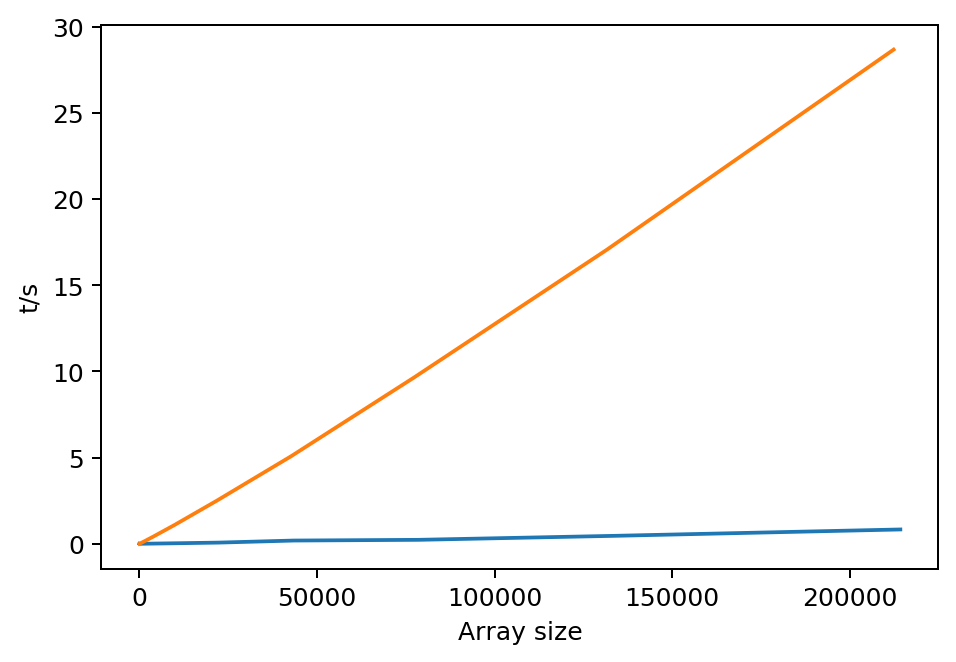

Check fEvals for consistency:
[    0.   -12.   -42.   -98.  -188.  -320.  -502.  -742. -1048. -1428.
 -1890.]


In [14]:
# Compare with Matlab benchmarks (not even funny...!)
x = loadmat(r'wigner3j_bench_t_090819.mat') 
w3jBenchMatlab = x['w3jbench']

plt.figure(dpi = 180)
plt.plot(fEvals[:,1], tDeltas)
plt.plot(w3jBenchMatlab[1:,1], w3jBenchMatlab[1:,2])
plt.xlabel('Array size')
plt.ylabel('t/s')
plt.show()

print('Check fEvals for consistency:')
print(w3jBenchMatlab[1:,1] - fEvals[:,1])

Note slight difference in overall fn. evals (probably an extraneous extra loop in Matlab code), but won't make a significant difference here.